In [2]:
import numpy as np
from numba import njit
import pickle
import time, sys

from scipy.optimize import curve_fit
from scipy.interpolate import splrep, splev
from scipy.linalg import eigh

import matplotlib.pyplot as plt

In [3]:
n_orb = 3

def FockState(index):
    return np.array(list(np.binary_repr(index - 1, width=2*n_orb)), dtype=int)

def FockIndex(bin_):
    return int("".join(str(x) for x in bin_), 2) + 1

def FermiCop(flavor):
    def condition(index):
        return FockState(index)[flavor-1] == 0

    indices = [index for index in range(1, 4**n_orb + 1) if condition(index)]
    sum_matrix = np.zeros((4**n_orb, 4**n_orb))
    for index in indices:
        state = FockState(index)
        phase = (-1)**np.sum(state[:flavor])
        updated_state = np.copy(state)
        updated_state[flavor-1] = 1
        sum_matrix += phase * np.outer(np.eye(4**n_orb)[index-1], np.eye(4**n_orb)[FockIndex(updated_state)-1])
    return sum_matrix

def FillBasis(occu):
    def condition(index):
        return np.sum(FockState(index)) == occu

    return [np.eye(4**n_orb)[index-1] for index in range(1, 4**n_orb + 1) if condition(index)]

cun = np.array([FermiCop(i) for i in range(1, n_orb+1)]).astype(np.csingle)
cdn = np.array([FermiCop(i) for i in range(n_orb+1, 2*n_orb+1)]).astype(np.csingle)
cn = np.array([FermiCop(i) for i in range(1, 2*n_orb+1)]).astype(np.csingle)


In [4]:
d1 = np.array([np.sqrt(3)/2, 0.5])
d2 = np.array([-np.sqrt(3)/2, 0.5])
d3 = np.array([0, -1])
E_A = 1


@njit
def dot(kx, ky, d):
    return kx * d[0] + ky * d[1]

# Define the functions f(kx, ky) and g(kx, ky)
@njit
def f(kx, ky):
    return (-np.exp(1j * dot(kx, ky, d1)) 
            - np.exp(-1j * 2 * np.pi / 3) * np.exp(1j * dot(kx, ky, d2)) 
            - np.exp(1j * 2 * np.pi / 3) * np.exp(1j * dot(kx, ky, d3)))

@njit
def g(kx, ky):
    return (np.exp(-1j * dot(kx, ky, d1)) 
            + np.exp(-1j * 2 * np.pi / 3) * np.exp(-1j * dot(kx, ky, d2)) 
            + np.exp(1j * 2 * np.pi / 3) * np.exp(-1j * dot(kx, ky, d3)))

@njit
def hamil(kx, ky):
    return np.array([[E_A, f(kx, ky), g(kx, ky)], 
                     [np.conj(f(kx, ky)), 0, 0], 
                     [np.conj(g(kx, ky)), 0, 0]], dtype=np.complex128)

@njit
def hamiltonian(nonint, mu, U):
    nonint_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    U_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    mu_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    B_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    B = 100
    for i in range(n_orb):
        for j in range(n_orb):
            nonint_term += np.dot(cun[i].T, cun[j]) * nonint[i, j]
            #nonint_term += np.dot(cdn[i].T, cdn[j]) * nonint[i, j]
    U_term += np.dot(np.dot(cun[0].T , cun[0]) ,np.dot( cun[1].T ,cun[1])) * U
    U_term += np.dot(np.dot(cun[0].T , cun[0]) ,np.dot( cun[2].T ,cun[2])) * U
    for i in range(n_orb):
        mu_term += -mu * (cun[i].T @ cun[i])
        B_term+= B*(cdn[i].T @ cdn[i])
    
    # Total Hamiltonian
    H = nonint_term + mu_term + U_term + B_term
    return H+np.eye(4**n_orb, dtype=np.csingle)*U

@njit
def fullhamil(kx, ky, t, mu, U):
    return hamiltonian(-t * hamil(kx, ky), mu, U)

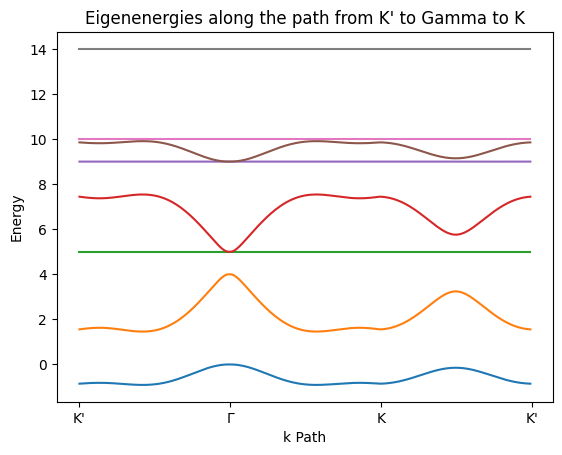

In [5]:
# Define the k points
a = 1 # Lattice constant
Kpoint = np.array([4 * np.pi / (3 * a), 0])
Kprime = np.array([2 * np.pi / (3 * a), 2 * np.pi / (np.sqrt(3) * a)])
GammaPoint = np.array([0, 0])

# Define the k path from K' to Gamma to K and then back to K'
kPath1 = np.array([[Kprime[0] * (1 - t), Kprime[1] * (1 - t)] for t in np.linspace(0, 1, 100)])
kPath2 = np.array([[GammaPoint[0] * (1 - t) + Kpoint[0] * t, GammaPoint[1] * (1 - t) + Kpoint[1] * t] for t in np.linspace(0, 1, 100)])
kPath3 = np.array([[Kpoint[0] * (1 - t) + Kprime[0] * t, Kpoint[1] * (1 - t) + Kprime[1] * t] for t in np.linspace(0, 1, 100)])

# Combine the paths
kPath = np.vstack((kPath1, kPath2, kPath3))

@njit
def compute_eigenvalues(kPath):
    eigenvalues = np.zeros((len(kPath), 64), dtype=np.complex128)
    for i in range(len(kPath)):
        kx, ky = kPath[i]
        eigenvalues[i, :] = np.linalg.eigvalsh(fullhamil(kx, ky, 1, 5, 10))
    return eigenvalues

eigenvalues = compute_eigenvalues(kPath)

# Extract the real part of the eigenvalues for plotting
eigenvalues_real = eigenvalues.real

# Define the k values for plotting
kValues = np.arange(len(kPath))

# Plot all 64 eigenenergies
for i in range(8):
    plt.plot(kValues, eigenvalues_real[:, i], label=f"E{i+1}")

# Adding labels and title
plt.xlabel("k Path")
plt.ylabel("Energy")
plt.title("Eigenenergies along the path from K' to Gamma to K")

# Adding tick marks
plt.xticks([0, len(kPath1), len(kPath1) + len(kPath2), len(kPath)], ["K'", "\u0393", "K", "K'"])
#plt.ylim(-2.5, 15)
# Show plot
plt.show()


In [ ]:
# Define epsilon tensor
epsilon_tensor = np.zeros((3, 3, 3))
epsilon_tensor[0, 1, 2] = 1
epsilon_tensor[1, 2, 0] = 1
epsilon_tensor[2, 0, 1] = 1
epsilon_tensor[2, 1, 0] = -1
epsilon_tensor[1, 0, 2] = -1
epsilon_tensor[0, 2, 1] = -1

@njit
def green_function(kx, ky, omega, t, mu, U):
    H_k = fullhamil(kx, ky, t, mu, U)
    identity_matrix = np.eye(H_k.shape[0], dtype=np.complex128)
    return np.linalg.inv(omega * identity_matrix - H_k)

@njit
def green_function_inv(kx, ky, omega, t, mu, U):
    H_k = fullhamil(kx, ky, t, mu, U)
    identity_matrix = np.eye(H_k.shape[0], dtype=np.complex128)
    return omega * identity_matrix - H_k


def partial_derivative(func, var, delta=1e-5):
    return (func(var + delta) - func(var - delta)) / (2 * delta)


def integrand(kx, ky, omega, t, mu, U):
    G_inv = green_function_inv(kx, ky, omega, t, mu, U)
    G = green_function(kx, ky, omega, t, mu, U)
    
    dG_inv_dkx = partial_derivative(lambda kx_: green_function_inv(kx_, ky, omega, t, mu, U), kx)
    dG_inv_dky = partial_derivative(lambda ky_: green_function_inv(kx, ky_, omega, t, mu, U), ky)
    dG_inv_domega = partial_derivative(lambda omega_: green_function_inv(kx, ky, omega_, t, mu, U), omega)
    
    term1 = np.dot(G, dG_inv_dkx)
    term2 = np.dot(term1, G)
    term3 = np.dot(term2, dG_inv_dky)
    term4 = np.dot(term3, G)
    term5 = np.dot(term4, dG_inv_domega)
    term6 = np.dot(term5, G)
    
    return np.trace(np.dot(epsilon_tensor[0, 1, 2], term6))


def N3(t, mu, U):
    kx_vals = np.linspace(-np.pi, np.pi, 50)
    ky_vals = np.linspace(-np.pi, np.pi, 50)
    omega_vals = np.linspace(-10, 10, 50)
    
    integral_sum = 0.0
    for kx in kx_vals:
        for ky in ky_vals:
            for omega in omega_vals:
                integral_sum += integrand(kx, ky, omega, t, mu, U)
    
    dkx = kx_vals[1] - kx_vals[0]
    dky = ky_vals[1] - ky_vals[0]
    domega = omega_vals[1] - omega_vals[0]
    
    return (1 / (6 * (2 * np.pi)**2)) * integral_sum * dkx * dky * domega

# Example usage:
t, mu, U = 1.0, 0.5, 2.0
topological_invariant = N3(t, mu, U)
print("Topological invariant N3:", topological_invariant)
